# Project | NLP Automated Customers Reviews

The goal of this project is to automate the processing of customer reviews by comparing traditional machine learning (ML) methods with a deep learning approach (transformers). Additionally, the project aims to use Generative AI to summarize reviews based on ratings and product categories and to create a visualization dashboard.

## Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

## Load & Explore Dataset

In [5]:
import pandas as pd

# Load dataset
data_path = "1429_1.csv"

# df = pd.read_csv(data_path)

# Colab
df = pd.read_csv(data_path,
                 # error_bad_lines=False,
                 #quoting=3,
                 #engine="python",
                 #on_bad_lines='warn'
                 )

#  Relevant columns
# 'reviews.text', 'reviews.title', 'reviews.rating'

<ipython-input-5-3edc2adaa3b4>:9: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path,


### EDA on the dataset

Average Sentence Length: 30.40 words
Max Length: 1858.00 words
Min Length: 1.00 words


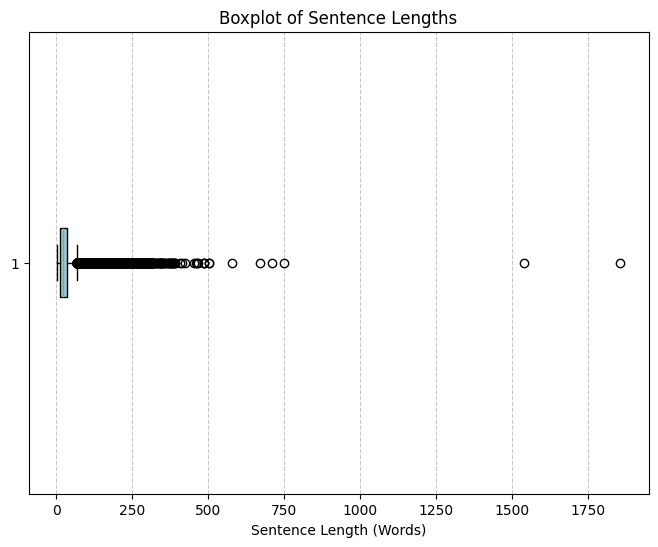

In [6]:
import matplotlib.pyplot as plt

# Calculate sentence lengths (split by spaces)
sentence_lengths = df['reviews.text'].astype(str).apply(lambda x: len(x.split()))

# Compute the average sentence length
avg_length = sentence_lengths.mean()
max_length = sentence_lengths.max()
min_length = sentence_lengths.min()

print(f"Average Sentence Length: {avg_length:.2f} words")
print(f"Max Length: {max_length:.2f} words")
print(f"Min Length: {min_length:.2f} words")


# Generate a boxplot for sentence lengths
plt.figure(figsize=(8, 6))
plt.boxplot(sentence_lengths, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'))
plt.xlabel('Sentence Length (Words)')
plt.title('Boxplot of Sentence Lengths')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

MAX_SENTENCE_LENGTH = 500  # few sentences longer than 500

def truncate_sentence(sentence):
    words = sentence.split()  # Split sentence into words
    return " ".join(words[:MAX_SENTENCE_LENGTH])  # Keep only first N words




In [7]:
!pip install unidecode
!python -m spacy download en_core_web_lg
import unidecode
import spacy
import logging
import time

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Start timer for execution tracking
start_time = time.time()

# Log: Start of preprocessing
logging.info("Starting data preprocessing...")

# Map ratings to sentiment labels
# # 1,2,3 -> 'NEGATIVE'
# 4 -> 'NEUTRAL'
# 5 -> 'POSITIVE'

df['sentiment'] = df['reviews.rating'].map({
    1: 'NEGATIVE',
    2: 'NEGATIVE',
    3: 'NEGATIVE',
    4: 'NEUTRAL',
    5: 'POSITIVE'
})


# Ensure all text values are strings before applying unidecode
logging.info("Converting all text values to string format...")
df['reviews.text'] = df['reviews.text'].astype(str).apply(unidecode.unidecode)


# Log: Loading NLP Model
logging.info("Loading spacy model: en_core_web_lg")
nlp = spacy.load('en_core_web_lg')


def preprocess_text(text):
    # process the Text with spacy
    doc = nlp(text.lower())
    # Filter and Lemmatize Tokens
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Log: Applying text preprocessing
logging.info("Applying text preprocessing to all reviews...")
df['clean_text'] = df['reviews.text'].apply(preprocess_text)

# Log: Time taken
end_time = time.time()
logging.info(f"Total execution time: {end_time - start_time:.2f} seconds")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Feature Extraction

In [9]:
import logging
import time
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Log: Start of preprocessing
logging.info("Starting data preprocessing and train-test split...")

# Define X (features) and y (target labels)
X = df["clean_text"]  # Features (processed text)
y = df["sentiment"]   # Target labels (POSITIVE, NEUTRAL, NEGATIVE)

# Log: Checking for NaN values
initial_size = len(df)
nan_count = df[['clean_text', 'sentiment']].isna().sum().sum()
logging.info(f"Found {nan_count} missing values. Removing them...")

# Drop rows with NaN values in critical columns
df_clean = df.dropna(subset=["clean_text", "sentiment"])

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Function to split sentences and explode into multiple rows
def split_long_sentences(text, max_length=500):
    sentences = sent_tokenize(text)  # Split into sentences
    return [s for s in sentences if len(s.split()) <= max_length]  # Keep reasonable length

# Apply and explode (create multiple rows per sentence)
df['split_clean_text'] = df['clean_text'].apply(split_long_sentences)
df_exploded = df.explode('split_clean_text')  # Each sentence in a new row

# Log: Data size after cleaning
final_size = len(df_clean)
logging.info(f"Data cleaned: {initial_size - final_size} rows removed. Remaining rows: {final_size}")

# Update X and y with cleaned data
X = df_clean["clean_text"]
y = df_clean["sentiment"]

# Log: Splitting dataset
logging.info("Splitting data into training (80%) and test (20%) sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Log: Summary of dataset split
logging.info(f"Training set size: {len(X_train)} samples")
logging.info(f"Test set size: {len(X_test)} samples")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#  apply TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit only on training data
X_test_tfidf = vectorizer.transform(X_test)  # Transform test data using the same vectorizer

## Traditional ML model Training & Evaluation

2025-01-30 15:41:21,883 - INFO - Training Logistic Regression model...
2025-01-30 15:41:23,022 - INFO - Model Accuracy: 0.72
2025-01-30 15:41:23,134 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.64      0.25      0.36       462
     NEUTRAL       0.50      0.22      0.30      1708
    POSITIVE       0.75      0.94      0.84      4756

    accuracy                           0.72      6926
   macro avg       0.63      0.47      0.50      6926
weighted avg       0.68      0.72      0.67      6926



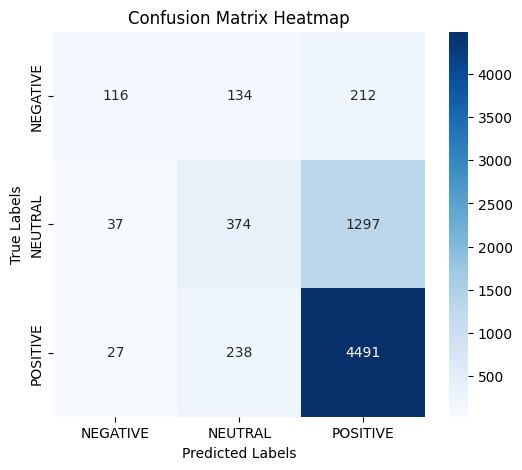

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Logistic Regression model
logging.info("Training Logistic Regression model...")
model = LogisticRegression(max_iter=500)  # Increase iterations for convergence
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
logging.info(f"Model Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, y_pred)
logging.info("\nClassification Report:\n" + report)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ["NEGATIVE", "NEUTRAL", "POSITIVE"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()


Paola: Podemos poner par de los demas algoritmos y hacer hyperparameter tuning.  

# Transformer approach

'bert-base-multilingual-uncased-sentiment'
https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

This is a bert-base-multilingual-uncased model finetuned for sentiment analysis on product reviews in six languages: English, Dutch, German, French, Spanish, and Italian. It predicts the sentiment of the review as a number of stars (between 1 and 5).

This model is intended for direct use as a sentiment analysis model for product reviews in any of the six languages above or for further finetuning on related sentiment analysis tasks.


NOTA: ESTO SE COGE UN MONTON DE TIEMPO.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Function to predict sentiment
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Get model predictions
    outputs = model(**inputs)
    logits = outputs.logits

    # Convert logits to prob
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Get the predicted label (highest probability)
    predicted_class = torch.argmax(probs, dim=1).item()

    # Map the predicted class to a sentiment
    sentiment_map = {
        0: "NEGATIVE",
        1: "NEGATIVE",
        2: "NEUTRAL",
        3: "POSITIVE",
        4: "POSITIVE",
    }

    # Convert probabilities to a dictionary
    probabilities_dict = {
        sentiment_map[i]: round(float(probs[0, i]) * 100, 2) for i in range(len(sentiment_map))
    }
    # Log the function output
    logging.info(f"Text: {text}")
    logging.info(f"Predicted Sentiment: {sentiment_map[predicted_class]}")
    logging.info(f"Probabilities: {probabilities_dict}")

    return sentiment_map[predicted_class], probabilities_dict

# trying it out on the data.
df["pretrained_sentiment"] = df["clean_text"].apply(lambda x: predict_sentiment(x)[0])





KeyboardInterrupt: 

## Fine-Tuning - TO DO

Paola: Me quede hasta aqui, en mi compu del trabajo no esta pa hacer fine tuning so sigo en casa.